# Neighborhoods in Toronto
The purpose of this notebook is to scrape and process Toronto neighborhood data

## Import Pandas

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv

## Scrape Table Cells from Wikipedia Article

Use Pandas' read_html() to pull all tabular data from the Wikipedia page:

In [37]:
dfs = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M", header=0)

## Create Dataframe

Create a dataframe from only the first table on the page, which is index 0.

In [41]:
rough_df = dfs[0]
rough_df.head()

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


## Remove "Not assigned" boroughs from the table

In [88]:
df = rough_df[rough_df["Borough"]!="Not assigned"]
df.reset_index(drop=True).head()

,Postal code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park / Harbourfront
3,M6A,North York,Lawrence Manor / Lawrence Heights
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


## Shape of the Dataframe

In [49]:
df.shape

(103, 3)

In [51]:
print("There are %d unique postal codes and %d columns in the dataframe"
    %(df.shape[0],df.shape[1]))

There are 103 unique postal codes and 3 columns in the dataframe


In [66]:
# The code was removed by Watson Studio for sharing.

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [67]:
df_data_1.shape

(103, 3)

## Change Geo Data Index to 'Postal Code'

In [82]:
geo_df = df_data_1.set_index("Postal Code")
geo_df.head()

,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


## Join Dataframes

In [93]:
df2 = df.join(geo_df, on="Postal code")
df2 = df2.reset_index(drop=True)
df2.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494


## Determine k-Means Optimal Cluster Count

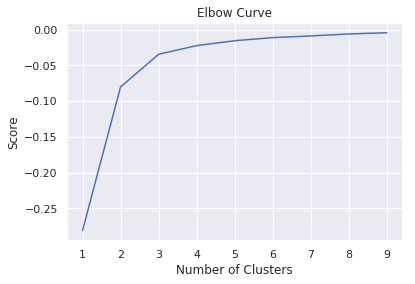

In [98]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
y_axis = df2[['Latitude']]
x_axis = df2[['Longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

# Graph out the scores by the number of clusters
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

There is definitely an elbow at 3 clusters!  Darn, I was guessing it would be 4 :)

## Now to actually determining the clusters...

In [102]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++')
kmeans.fit(df2[df2.columns[3:5]])

df2["Cluster Assignment"] = kmeans.fit_predict(df2[df2.columns[3:5]])

In [103]:
df2.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster Assignment
0,M3A,North York,Parkwoods,43.753259,-79.329656,2
1,M4A,North York,Victoria Village,43.725882,-79.315572,2
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636,1
3,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763,0
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494,1


In [112]:
labels = df2["Cluster Assignment"]

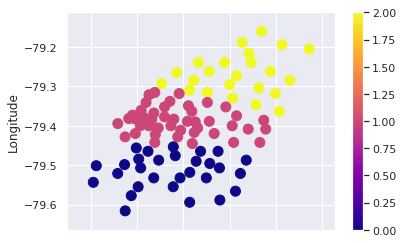

In [119]:
df2.plot.scatter(x = 'Latitude', y = 'Longitude', c=labels, s=100, cmap="plasma")

## Now to Plot the Clusters with Folium

### First we'll assign marker colors to each of the clusters:

In [172]:
marker_color = []
i=0

for number in df2["Cluster Assignment"]:
    if df2["Cluster Assignment"][i] == 2:
        marker_color.append("red")
    elif df2["Cluster Assignment"][i] == 1:
        marker_color.append("blue")
    else:
        marker_color.append("yellow")
    i+=1

marker_color[0:5]

['red', 'red', 'blue', 'yellow', 'blue']

### Add the markers to the dataframe

In [175]:
df2["Marker Color"] = marker_color

In [176]:
df2.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster Assignment,Marker Color
0,M3A,North York,Parkwoods,43.753259,-79.329656,2,red
1,M4A,North York,Victoria Village,43.725882,-79.315572,2,red
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636,1,blue
3,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763,0,yellow
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494,1,blue


### Install Folium and Create Map

In [197]:
!pip install folium

In [198]:
import folium

In [199]:
m=folium.Map(location=[43.753259, -79.329656], zoom_start=11)
for i in range(0,len(df2)):
    folium.CircleMarker(([df2.iloc[i]['Latitude'], df2.iloc[i]['Longitude']]), popup=df2.iloc[i]['Neighborhood'], fill=True, fill_opacity=.3, fill_color=df2.iloc[i]['Marker Color'], color=df2.iloc[i]['Marker Color']).add_to(m)
m